In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import nltk
import matplotlib.pyplot as plt
import sklearn_crfsuite
import gensim
import sys
import warnings
import torch

from collections import Counter
from tqdm import tqdm_notebook
from sklearn.metrics import make_scorer
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from transformers import BertModel, BertConfig, BertTokenizer

warnings.filterwarnings("ignore")
sys.path.append("study/5course/NLP-mipt/hw2/")

from src.learner import NerLearner, validate_step, predict

---
# Part 1 Analyze and prepare.

In [2]:
train = pd.read_csv('train.csv', sep=',')
test = pd.read_csv('valid_tokens.csv', sep=',')

In [3]:
train.head()

,Unnamed: 0,tokens,tags
0,0,В Пакистане роходят акции исламистов против от...,O B_LOC O O O O O B_ORG I_ORG O B_PER
1,1,Как сообщает Пакистанская служба Радио Свобода...,O O B_ORG I_ORG I_ORG I_ORG O O B_LOC O O O O ...
2,2,В городе Карачи ющие жгли шины .,O O B_LOC O O O O
3,3,В провинции Пенджаб толкновения с полицией .,O O B_LOC O O O O
4,4,Пакистанские силы безопасности установили охра...,O O O O O O O O O


In [4]:
print('train len is: %d' % len(train))
print('test len is: %d' % len(test))

train len is: 3788
test len is: 2714


Удалим nan значения из данных

In [5]:
train = train[train['tokens'].notna()]
test = test[test['tokens'].notna()]

In [6]:
print('train len is: %d' % len(train))
print('test len is: %d' % len(test))

train len is: 3783
test len is: 2714


---
###### 1.1. Analyze distribution of labels and plot.
---

In [7]:
labels = ' '.join(list(train['tags'])).split(' ')
labels_unique = np.unique(labels)

In [8]:
print('amount of labels is %d' % len(labels))
print('amount of unique labels is %d' % len(labels_unique))
print('labels: ' + str(labels_unique))

amount of labels is 59029
amount of unique labels is 11
labels: ['B_EVT' 'B_LOC' 'B_ORG' 'B_PER' 'B_PRO' 'I_EVT' 'I_LOC' 'I_ORG' 'I_PER'
 'I_PRO' 'O']


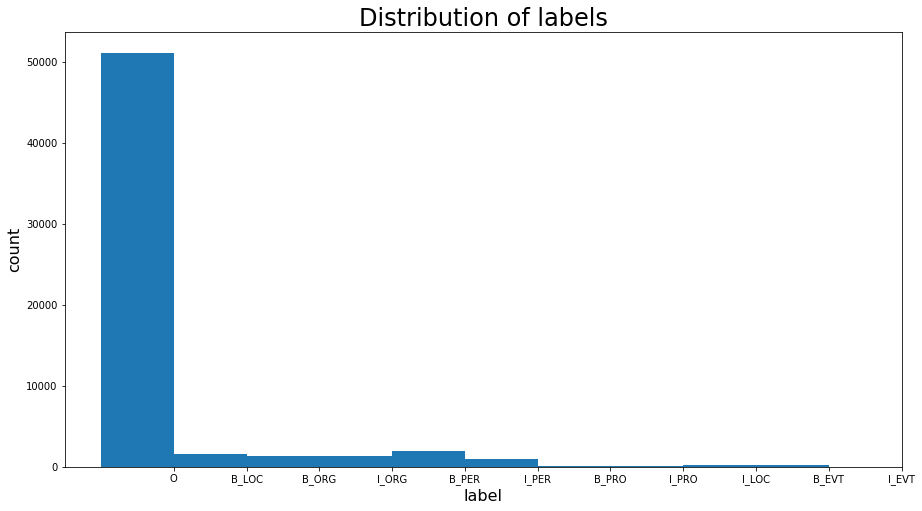

In [9]:
labels_dist = Counter(labels)

plt.figure(figsize=(15, 8))
plt.hist(labels, bins=np.arange(11) - 0.5)
plt.xticks(0.5 + np.arange(len(labels_dist.keys())), labels_dist.keys())
plt.title('Distribution of labels', fontsize=24)
plt.xlabel('label', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.show()

---
Как видим, большая часть лейблов не относится ни к одному из классов.

Посмотрим на распределение лейблов, относящихся к какому-то из классов.

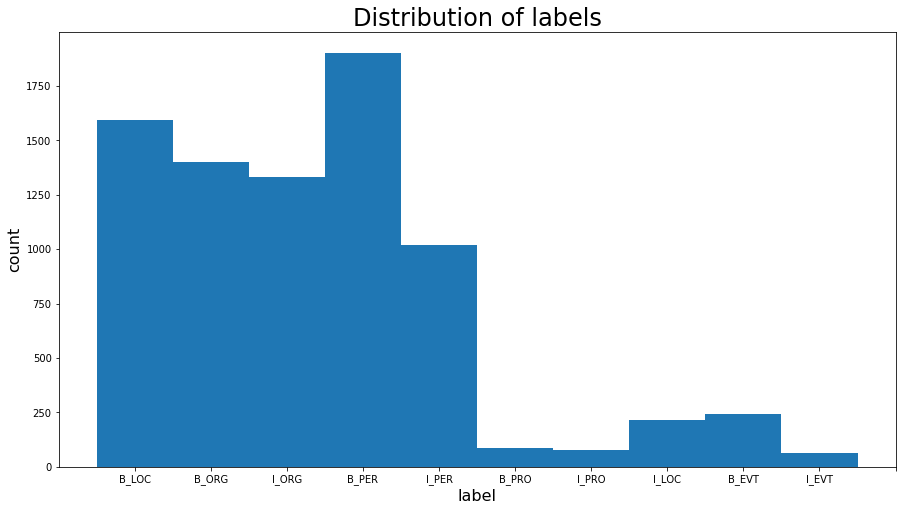

In [10]:
labels_wo_O = list(filter(lambda x: x != 'O', labels))

labels_dist = Counter(labels_wo_O)

plt.figure(figsize=(15, 8))
plt.hist(labels_wo_O, bins=np.arange(11) - 0.5)
plt.xticks(np.arange(len(labels_dist.keys()) + 1), labels_dist.keys())
plt.title('Distribution of labels', fontsize=24)
plt.xlabel('label', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.show()

---
###### 1.2. Remove unexcepted labels from data (if need) and describe how (if need).

В задаче нас просят классифицировать слова на 6 классов, в то время как в датасете встречаются 11 классов.

Удалим предложения, в которых встречаются неуместные лейблы (~250 предложений). Это самый простой подход, который уменьшит нам объём данных для обучения, но для начала сойдет. (можно еще заменить все unexpected labels на "O" и сравнить результаты).

Также удалим плохие предложения, после токенизации которых количество меток не совпадает с количеством токенов (~70 предложений).

In [11]:
labels_remain = set(['B_ORG', 'I_PER', 'I_LOC', 'I_ORG', 'B_LOC', 'B_PER', 'O'])
labels = list(train['tags'])

is_remained = [set(l.split(' ')).issubset(labels_remain) for l in labels]

percentage = 100. * (len(train) - sum(is_remained)) / len(train)
train = train[is_remained]

print('deleted sentences are %.2f percents of train set' % percentage)

deleted sentences are 8.41 percents of train set


---
# Part 2 Your own baseline.
###### 2.1 Make your own baseline with this tutorial https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html.

In [12]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [13]:
X_train = []
y_train = []
X_test = []

for i, row in tqdm_notebook(train.iterrows()):
    tokens = row[1].split(' ')
    pos = nltk.pos_tag(tokens)
    X_train.append(sent2features(pos))
    y_train.append(row[2].split(' '))
    
for i, row in tqdm_notebook(test.iterrows()):
    tokens = row[1].split(' ')
    pos = nltk.pos_tag(tokens)
    X_test.append(sent2features(pos))

In [14]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 5.93 s, sys: 35.3 ms, total: 5.97 s
Wall time: 6.01 s


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [15]:
y_pred = crf.predict(X_train)

metrics.flat_f1_score(y_train, y_pred,
                     average='macro', labels=list(crf.classes_))

0.9927993427213615

---
Все обучается, перейдём к кросс-валидации.

---
###### 2.2 Make crossvalidation.

In [258]:
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': sps.expon(scale=0.5),
    'c2': sps.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='macro')

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)

In [261]:
%%time
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 18.1min finished


CPU times: user 16min 29s, sys: 5 s, total: 16min 34s
Wall time: 18min 15s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None,...
                                 verbose=False),
                   iid='warn', n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f824d545550>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f824d50afd0>},
        

In [297]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.0036354063261784474, 'c2': 0.06156758465482312}
best CV score: 0.7289647227932926
model size: 1.75M


In [300]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=rs.best_params_['c1'],
    c2=rs.best_params_['c2'],
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.0036354063261784474, c2=0.06156758465482312,
    calibration_candidates=None, calibration_eta=None,
    calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [301]:
y_pred = crf.predict(X_test)

In [302]:
lbl_dict = {'B_ORG': 0, 'I_PER': 1, 'I_LOC': 2, 'I_ORG': 3, 'B_LOC': 4, 'B_PER': 5, 'O': 6}

submission_list = []

for row in y_pred:
    for lbl in row:
        submission_list.append(lbl_dict[lbl])

In [309]:
submission = pd.DataFrame({'Id': np.arange(len(submission_list)), 'Predicted': submission_list})

In [304]:
submission.to_csv('submission_baseline.csv', index=False)

---
Данный submission набрал 0.615 f1-score на тестовых данных на kaggle с гиперпараметрами $\text{c1}=0.0036$, $\text{c2}=0.061$.

Использовавшиеся фичи:

1. word.lower() - токен в нижнем регистре
2. word.isupper() - флаг, записан ли токен в верхнем регистре
3. word.istitle() - флаг, начинается ли токен с заглавной буквы
4. postag - тэг токена
5. postag[:2] - первые 2 символа тэга
6. фичи 1-5 для соселних токенов
7. word.isdigit() - флаг, является ли токен числом
8. word[-3:] - суффикс токена длины 3
9. word[-2:] - суффикс токена длины 2
10. BOS - флаг, является ли токен первым в предложении
11. EOS - флаг, является ли токен последним в предложении

Все эти фичи взяты из туториала https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html

---
# Part 3. Your favorite ml algorithm.

---
###### 3.1 Make submission to leaderboard and beat a baseline with your favorite ML algorithm (0.55 macro f1).

подход №1: rusVectores embedding + BiLSTM + CRF

---
разобъем данные на обучение и валидацию

In [14]:
train_data, val_data = train_test_split(train, test_size=0.1, random_state=42)
test_data = test.copy()

labels = []
for i, row in test_data.iterrows():
    labels.append(' '.join(['O'] * len(row[1].split(' '))))

test_data['labels'] = labels

train_data.columns = ['id', 'text', 'labels']
val_data.columns = ['id', 'text', 'labels']
test_data.columns = ['id', 'text', 'labels']

In [15]:
train_data.to_csv('train_data.csv', sep='\t')
val_data.to_csv('val_data.csv', sep='\t')
test_data.to_csv('test_data.csv', sep='\t')

---
загрузим модель эмбеддингов с rusVectores

In [16]:
model = gensim.models.KeyedVectors.load('model.model')

INFO:gensim.utils:loading Word2VecKeyedVectors object from model.model
INFO:gensim.utils:loading vectors from model.model.vectors.npy with mmap=None
INFO:gensim.utils:loading vectors_vocab from model.model.vectors_vocab.npy with mmap=None
INFO:gensim.utils:loading vectors_ngrams from model.model.vectors_ngrams.npy with mmap=None
INFO:gensim.utils:setting ignored attribute vectors_norm to None
INFO:gensim.utils:setting ignored attribute vectors_vocab_norm to None
INFO:gensim.utils:setting ignored attribute vectors_ngrams_norm to None
INFO:gensim.utils:setting ignored attribute buckets_word to None
INFO:gensim.utils:loaded model.model


In [17]:
learn = NerLearner(
    train_df_path="~/study/5course/NLP-mipt/hw2/train_data.csv",
    valid_df_path="~/study/5course/NLP-mipt/hw2/val_data.csv",
    test_df_path="~/study/5course/NLP-mipt/hw2/test_data.csv",
    embedder=model,
    tensorboard_dir="logs",
    hidden_dim=1024,
    lr=0.0004,
    use_embeds=False
)

In [18]:
learn.fit(10)

INFO:root:Start training. Total epochs 10.
INFO:root:                                                                       
epoch 1, average train epoch loss=17.938

  0%|          | 0/195 [00:00<?, ?it/s]        

              precision    recall  f1-score   support

       B_LOC      0.659     0.513     0.577       158
       B_ORG      0.619     0.106     0.181       123
       B_PER      0.555     0.426     0.482       190
       I_LOC      0.000     0.000     0.000        14
       I_ORG      0.667     0.042     0.078        96
       I_PER      0.818     0.094     0.168        96
           O      0.922     0.992     0.956      4841

    accuracy                          0.904      5518
   macro avg      0.606     0.310     0.349      5518
weighted avg      0.886     0.904     0.880      5518



INFO:root:                                                                       
epoch 2, average train epoch loss=4.5087

train loss: 3.6290786266326904:   0%|          | 0/195 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       B_LOC      0.818     0.709     0.759       158
       B_ORG      0.732     0.423     0.536       123
       B_PER      0.789     0.747     0.768       190
       I_LOC      1.000     0.143     0.250        14
       I_ORG      0.535     0.396     0.455        96
       I_PER      0.882     0.698     0.779        96
           O      0.957     0.985     0.971      4841

    accuracy                          0.939      5518
   macro avg      0.816     0.586     0.645      5518
weighted avg      0.934     0.939     0.934      5518



INFO:root:                                                                       
epoch 3, average train epoch loss=3.294

train loss: 3.167675733566284:   1%|          | 2/195 [00:00<00:13, 14.32it/s]

              precision    recall  f1-score   support

       B_LOC      0.870     0.722     0.789       158
       B_ORG      0.680     0.537     0.600       123
       B_PER      0.813     0.779     0.796       190
       I_LOC      1.000     0.143     0.250        14
       I_ORG      0.604     0.635     0.619        96
       I_PER      0.922     0.740     0.821        96
           O      0.965     0.982     0.973      4841

    accuracy                          0.945      5518
   macro avg      0.836     0.648     0.693      5518
weighted avg      0.944     0.945     0.943      5518



INFO:root:                                                                       
epoch 4, average train epoch loss=2.779

train loss: 2.7176783084869385:   1%|          | 2/195 [00:00<00:13, 14.40it/s]

              precision    recall  f1-score   support

       B_LOC      0.867     0.741     0.799       158
       B_ORG      0.650     0.618     0.633       123
       B_PER      0.853     0.795     0.823       190
       I_LOC      0.500     0.143     0.222        14
       I_ORG      0.638     0.625     0.632        96
       I_PER      0.906     0.802     0.851        96
           O      0.969     0.982     0.975      4841

    accuracy                          0.949      5518
   macro avg      0.769     0.672     0.705      5518
weighted avg      0.947     0.949     0.947      5518



INFO:root:                                                                       
epoch 5, average train epoch loss=2.3862

train loss: 2.39485502243042:   1%|          | 2/195 [00:00<00:13, 14.15it/s]

              precision    recall  f1-score   support

       B_LOC      0.873     0.741     0.801       158
       B_ORG      0.644     0.618     0.631       123
       B_PER      0.847     0.789     0.817       190
       I_LOC      0.600     0.214     0.316        14
       I_ORG      0.588     0.625     0.606        96
       I_PER      0.886     0.812     0.848        96
           O      0.971     0.981     0.976      4841

    accuracy                          0.949      5518
   macro avg      0.773     0.683     0.714      5518
weighted avg      0.947     0.949     0.947      5518



INFO:root:                                                                       
epoch 6, average train epoch loss=2.1559

train loss: 2.167495846748352:   1%|          | 2/195 [00:00<00:13, 14.17it/s]

              precision    recall  f1-score   support

       B_LOC      0.873     0.741     0.801       158
       B_ORG      0.646     0.593     0.619       123
       B_PER      0.847     0.789     0.817       190
       I_LOC      0.667     0.286     0.400        14
       I_ORG      0.619     0.625     0.622        96
       I_PER      0.892     0.865     0.878        96
           O      0.970     0.981     0.976      4841

    accuracy                          0.949      5518
   macro avg      0.788     0.697     0.730      5518
weighted avg      0.948     0.949     0.948      5518



INFO:root:                                                                       
epoch 7, average train epoch loss=2.0002

train loss: 2.1292781829833984:   1%|          | 2/195 [00:00<00:14, 13.70it/s]

              precision    recall  f1-score   support

       B_LOC      0.881     0.753     0.812       158
       B_ORG      0.667     0.585     0.623       123
       B_PER      0.859     0.800     0.828       190
       I_LOC      0.667     0.286     0.400        14
       I_ORG      0.630     0.604     0.617        96
       I_PER      0.882     0.854     0.868        96
           O      0.970     0.983     0.976      4841

    accuracy                          0.951      5518
   macro avg      0.794     0.695     0.732      5518
weighted avg      0.948     0.951     0.949      5518



INFO:root:                                                                       
epoch 8, average train epoch loss=1.8894

train loss: 1.9832584857940674:   1%|          | 2/195 [00:00<00:13, 14.27it/s]

              precision    recall  f1-score   support

       B_LOC      0.868     0.747     0.803       158
       B_ORG      0.710     0.577     0.637       123
       B_PER      0.852     0.789     0.820       190
       I_LOC      0.444     0.286     0.348        14
       I_ORG      0.644     0.604     0.624        96
       I_PER      0.901     0.854     0.877        96
           O      0.968     0.983     0.976      4841

    accuracy                          0.950      5518
   macro avg      0.770     0.692     0.726      5518
weighted avg      0.948     0.950     0.949      5518



INFO:root:                                                                       
epoch 9, average train epoch loss=1.8264

train loss: 1.7917031049728394:   1%|          | 2/195 [00:00<00:13, 13.84it/s]

              precision    recall  f1-score   support

       B_LOC      0.874     0.747     0.805       158
       B_ORG      0.689     0.577     0.628       123
       B_PER      0.853     0.795     0.823       190
       I_LOC      0.500     0.286     0.364        14
       I_ORG      0.624     0.604     0.614        96
       I_PER      0.882     0.854     0.868        96
           O      0.969     0.982     0.976      4841

    accuracy                          0.950      5518
   macro avg      0.770     0.692     0.725      5518
weighted avg      0.947     0.950     0.948      5518



INFO:root:                                                                       
epoch 10, average train epoch loss=1.8056



              precision    recall  f1-score   support

       B_LOC      0.874     0.747     0.805       158
       B_ORG      0.689     0.577     0.628       123
       B_PER      0.848     0.795     0.821       190
       I_LOC      0.500     0.286     0.364        14
       I_ORG      0.628     0.615     0.621        96
       I_PER      0.874     0.865     0.869        96
           O      0.969     0.982     0.976      4841

    accuracy                          0.950      5518
   macro avg      0.769     0.695     0.726      5518
weighted avg      0.947     0.950     0.948      5518



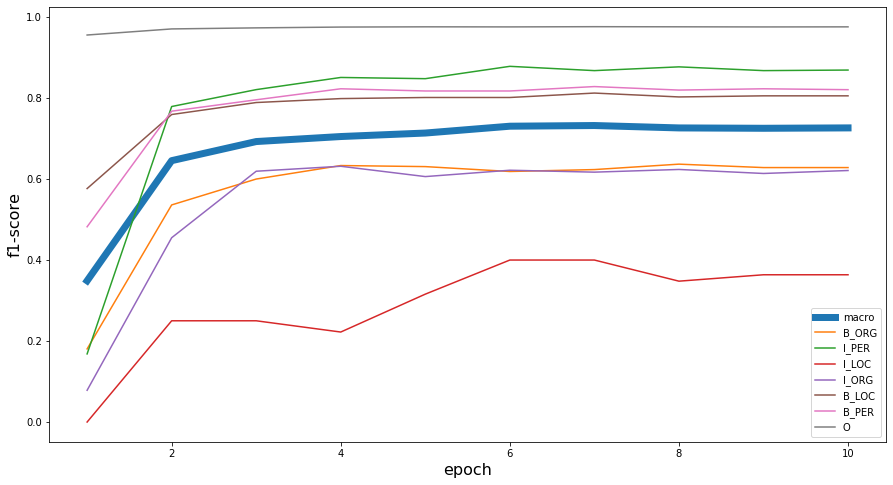

In [19]:
learn.plot_learning_curve()

Сформируем submission

In [ ]:
pred = predict(learn.data.test_dl, learn.model, learn.data.train_ds.idx2label)

In [35]:
lbl_dict = {'B_ORG': 0, 'I_PER': 1, 'I_LOC': 2, 'I_ORG': 3, 'B_LOC': 4, 'B_PER': 5, 'O': 6, '<pad>': 6}

submission_list = []

for row in pred:
    for lbl in row:
        submission_list.append(lbl_dict[lbl])

In [36]:
submission = pd.DataFrame({'Id': np.arange(len(submission_list)), 'Predicted': submission_list})
submission.to_csv('submission_BiLSTM_CRF_10_epochs.csv', index=False)

---
Подход №2: попробуем использовать предобученный BERT в качестве эмбеддера.

Для этого сначала подготовим словарь слов:

In [20]:
words = list(map(str.split, list(train.tokens))) + list(map(str.split, list(test.tokens)))
words = [item for w in words for item in w]
words.append('<pad>')

words = list(set(words))

---
Загрузим модель:

In [21]:
tokenizer = BertTokenizer.from_pretrained('./rubert_cased_L-12_H-768_A-12_pt')
model = BertModel.from_pretrained('./rubert_cased_L-12_H-768_A-12_pt')

---
Запишем все векторные представления слов из словаря в файл:

In [22]:
with open('bert.wv', 'a') as f:
    for w in tqdm_notebook(words):
        wv = model(**tokenizer(w, return_tensors='pt')).last_hidden_state[:, 0, :].reshape(-1).tolist()
        f.write(w + '\t' + str(wv) + '\n')

In [23]:
bert_wv = {}

with open('bert.wv', 'r') as f:
    for line in tqdm_notebook(f):
        text = line.split('\t')
        word = text[0]
        text = text[1].rstrip()
        bert_wv[word] = np.array(list(map(float, text[1:-1].split(', '))), dtype=np.float32)

In [24]:
class Bert():
    def __init__(self, wv):
        self.wv = wv
        
    def __getitem__(self, text):
        output = [self.wv[word] for word in text]
        return np.stack(output, axis=0)

In [25]:
model = Bert(wv=bert_wv)

In [26]:
learn = NerLearner(
    train_df_path="~/study/5course/NLP-mipt/hw2/train_data.csv",
    valid_df_path="~/study/5course/NLP-mipt/hw2/val_data.csv",
    test_df_path="~/study/5course/NLP-mipt/hw2/test_data.csv",
    embedder=model,
    tensorboard_dir="logs",
    embedding_size=768,
    hidden_dim=1024,
    lr=0.0004,
    use_embeds=False
)

In [27]:
learn.fit(10)

INFO:root:Start training. Total epochs 10.
INFO:root:                                                                       
epoch 1, average train epoch loss=13.986

train loss: 4.972865104675293:   0%|          | 0/195 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       B_LOC      0.810     0.323     0.462       158
       B_ORG      0.750     0.122     0.210       123
       B_PER      0.782     0.774     0.778       190
       I_LOC      0.000     0.000     0.000        14
       I_ORG      0.571     0.083     0.145        96
       I_PER      0.769     0.625     0.690        96
           O      0.936     0.996     0.965      4841

    accuracy                          0.925      5518
   macro avg      0.660     0.418     0.464      5518
weighted avg      0.911     0.925     0.906      5518



INFO:root:                                                                       
epoch 2, average train epoch loss=4.0856

train loss: 2.67067289352417:   0%|          | 0/195 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       B_LOC      0.782     0.728     0.754       158
       B_ORG      0.723     0.488     0.583       123
       B_PER      0.884     0.805     0.843       190
       I_LOC      1.000     0.071     0.133        14
       I_ORG      0.595     0.490     0.537        96
       I_PER      0.929     0.677     0.783        96
           O      0.964     0.988     0.976      4841

    accuracy                          0.947      5518
   macro avg      0.840     0.607     0.658      5518
weighted avg      0.944     0.947     0.943      5518



INFO:root:                                                                       
epoch 3, average train epoch loss=3.1159

train loss: 1.691235065460205:   0%|          | 0/195 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       B_LOC      0.817     0.734     0.773       158
       B_ORG      0.750     0.610     0.673       123
       B_PER      0.912     0.816     0.861       190
       I_LOC      1.000     0.286     0.444        14
       I_ORG      0.719     0.427     0.536        96
       I_PER      0.890     0.760     0.820        96
           O      0.968     0.992     0.980      4841

    accuracy                          0.954      5518
   macro avg      0.865     0.661     0.727      5518
weighted avg      0.951     0.954     0.951      5518



INFO:root:                                                                       
epoch 4, average train epoch loss=2.5777

train loss: 1.501739501953125:   0%|          | 0/195 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       B_LOC      0.847     0.703     0.768       158
       B_ORG      0.747     0.602     0.667       123
       B_PER      0.905     0.853     0.878       190
       I_LOC      0.800     0.286     0.421        14
       I_ORG      0.759     0.458     0.571        96
       I_PER      0.883     0.865     0.874        96
           O      0.970     0.992     0.981      4841

    accuracy                          0.957      5518
   macro avg      0.845     0.680     0.737      5518
weighted avg      0.954     0.957     0.954      5518



INFO:root:                                                                       
epoch 5, average train epoch loss=2.2482

train loss: 1.2653007507324219:   0%|          | 0/195 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       B_LOC      0.823     0.766     0.793       158
       B_ORG      0.784     0.707     0.744       123
       B_PER      0.930     0.842     0.884       190
       I_LOC      0.571     0.286     0.381        14
       I_ORG      0.770     0.594     0.671        96
       I_PER      0.884     0.875     0.880        96
           O      0.976     0.991     0.983      4841

    accuracy                          0.962      5518
   macro avg      0.820     0.723     0.762      5518
weighted avg      0.960     0.962     0.960      5518



INFO:root:                                                                       
epoch 6, average train epoch loss=2.0413

train loss: 1.154857873916626:   0%|          | 0/195 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       B_LOC      0.851     0.759     0.803       158
       B_ORG      0.756     0.732     0.744       123
       B_PER      0.911     0.863     0.886       190
       I_LOC      0.667     0.429     0.522        14
       I_ORG      0.784     0.604     0.682        96
       I_PER      0.840     0.927     0.881        96
           O      0.979     0.988     0.984      4841

    accuracy                          0.963      5518
   macro avg      0.827     0.758     0.786      5518
weighted avg      0.961     0.963     0.961      5518



INFO:root:                                                                       
epoch 7, average train epoch loss=1.863

train loss: 1.0706713199615479:   0%|          | 0/195 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       B_LOC      0.846     0.766     0.804       158
       B_ORG      0.780     0.748     0.763       123
       B_PER      0.907     0.874     0.890       190
       I_LOC      0.667     0.429     0.522        14
       I_ORG      0.768     0.656     0.708        96
       I_PER      0.840     0.927     0.881        96
           O      0.981     0.988     0.984      4841

    accuracy                          0.964      5518
   macro avg      0.827     0.770     0.793      5518
weighted avg      0.963     0.964     0.963      5518



INFO:root:                                                                       
epoch 8, average train epoch loss=1.7892

train loss: 1.1426951885223389:   0%|          | 0/195 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       B_LOC      0.854     0.778     0.815       158
       B_ORG      0.791     0.740     0.765       123
       B_PER      0.897     0.868     0.882       190
       I_LOC      0.600     0.429     0.500        14
       I_ORG      0.756     0.646     0.697        96
       I_PER      0.827     0.948     0.883        96
           O      0.981     0.987     0.984      4841

    accuracy                          0.963      5518
   macro avg      0.815     0.771     0.789      5518
weighted avg      0.962     0.963     0.963      5518



INFO:root:                                                                       
epoch 9, average train epoch loss=1.7269

train loss: 0.9938123226165771:   0%|          | 0/195 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       B_LOC      0.854     0.778     0.815       158
       B_ORG      0.800     0.683     0.737       123
       B_PER      0.921     0.863     0.891       190
       I_LOC      0.600     0.429     0.500        14
       I_ORG      0.700     0.656     0.677        96
       I_PER      0.840     0.927     0.881        96
           O      0.978     0.987     0.983      4841

    accuracy                          0.962      5518
   macro avg      0.813     0.761     0.783      5518
weighted avg      0.961     0.962     0.961      5518



INFO:root:                                                                       
epoch 10, average train epoch loss=1.704



              precision    recall  f1-score   support

       B_LOC      0.855     0.785     0.818       158
       B_ORG      0.802     0.724     0.761       123
       B_PER      0.921     0.863     0.891       190
       I_LOC      0.600     0.429     0.500        14
       I_ORG      0.677     0.656     0.667        96
       I_PER      0.840     0.927     0.881        96
           O      0.979     0.986     0.983      4841

    accuracy                          0.962      5518
   macro avg      0.811     0.767     0.786      5518
weighted avg      0.961     0.962     0.962      5518



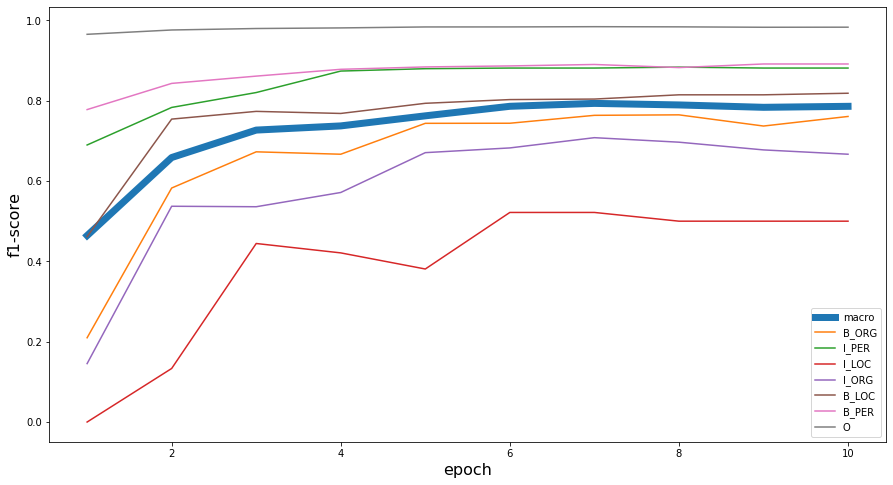

In [28]:
learn.plot_learning_curve()

Сформируем submission:

In [ ]:
pred = predict(learn.data.test_dl, learn.model, learn.data.train_ds.idx2label)

In [ ]:
lbl_dict = {'B_ORG': 0, 'I_PER': 1, 'I_LOC': 2, 'I_ORG': 3, 'B_LOC': 4, 'B_PER': 5, 'O': 6, '<pad>': 6}

submission_list = []

for row in pred:
    for lbl in row:
        submission_list.append(lbl_dict[lbl])

In [ ]:
submission = pd.DataFrame({'Id': np.arange(len(submission_list)), 'Predicted': submission_list})
submission.to_csv('submission_BERT_BiLSTM_CRF_10_epochs.csv', index=False)

---
# Part 4. Results.

Получившиеся результаты:

| метод         | f1-score      |
| ------------- |:-------------:|
| sclearn-CRF | 0.61 |
| Rusvectores embedder BiLSTM + CRF | 0.55 |
| Embedder + BiLSTM + CRF      | 0.36      |
| BERT embedder + BiLSTM + CRF | **0.65**      |

Наихудшее качество получается для лейблов I_LOC, I_ORG -- лейблов, указывающих на продолжение сущностей организации и локации.